In [1]:
#install deepface
# !git clone https://github.com/serengil/deepface.git
# !cd deepface
# !pip install -e .

Cloning into 'deepface'...


Obtaining file:///C:/Users/ADMIN/workspace/face_reg


ERROR: file:///C:/Users/ADMIN/workspace/face_reg does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [1]:
from time import time
import numpy as np

import matplotlib.pyplot as plt
import cv2 as cv
from deepface import DeepFace
from numba import jit
import faiss
from ultralytics import YOLO
from facenet_pytorch import InceptionResnetV1
import torch

In [2]:
resnet = InceptionResnetV1(pretrained='vggface2', device='cuda').eval()
yolo = YOLO("yolov8m-face.pt")

In [3]:
# load dataset function
import os

def load_dataset_from_images(dir, detector_name="yolov8"):
    embeddings = []
    labels = []

    for subdir in os.listdir(dir):
        print(subdir)
        for file in os.listdir(os.path.join(dir, subdir)):
            face = DeepFace.extract_faces(os.path.join(dir, subdir, file), detector_backend=detector_name)[0]
            with torch.no_grad():
                embedding = (
                    resnet(
                        torch.from_numpy(face["face"].copy())
                        .cuda()
                        .permute(2, 0, 1)
                        .unsqueeze(0)
                        .float()
                    )
                )[0]
            embeddings.append(embedding.cpu().numpy())

            labels.append(subdir)

    return np.asarray(embeddings), np.array(labels)

@jit
def add_data_to_dataset(
    dir, X, y, y_unique, modelname="Facenet", detector_name="retinaface"
):
    new_X = np.copy(X)
    new_y = np.copy(y)
    new_y_unique = np.copy(y_unique)

    label = os.path.basename(dir)

    new_y_unique = np.append(new_y_unique, label)

    for file in os.listdir(dir):
        embedding = DeepFace.represent(...)[0]["embedding"]

        new_X = np.append(new_X, [embedding], axis=0)

        label_idx = np.where(new_y_unique == label)[0][0]
        new_y = np.append(new_y, label_idx)

    return new_X, new_y, new_y_unique

@jit
def load_dataset_from_part(dir):
    embeddings = []
    labels = []
    labels_unique = []

    for filename in os.listdir(dir):
        if filename == "database.npz":
            continue
        X = np.load(os.path.join(dir, filename), allow_pickle=True)["X"]
        y = np.load(os.path.join(dir, filename), allow_pickle=True)["y"]
        y_unique = np.unique(y)

        labels_unique.extend(y_unique)
        embeddings.extend(X)
        labels.extend(y)
    labels = np.searchsorted(labels_unique, labels)
    np.savez_compressed("database/database.npz", X=embeddings, y=labels, target_names=labels_unique)

In [3]:
# Calculate Distance Function
# @jit
# def findCosineDistance(source_representation, test_representation):
#     a = np.matmul(np.transpose(source_representation), test_representation)
#     b = np.sum(np.multiply(source_representation, source_representation))
#     c = np.sum(np.multiply(test_representation, test_representation))
#     return 1 - (a / (np.sqrt(b) * np.sqrt(c)))

# @jit
# def findEuclideanDistance(source_representation, test_representation):
#     if isinstance(source_representation, list):
#         source_representation = np.array(source_representation)

#     if isinstance(test_representation, list):
#         test_representation = np.array(test_representation)

#     euclidean_distance = source_representation - test_representation
#     euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
#     euclidean_distance = np.sqrt(euclidean_distance)
#     return euclidean_distance
# @jit
# def l2_normalize(x):
#     return x / np.sqrt(np.sum(np.multiply(x, x)))


@jit
def findCosineDistance(source_representation, test_representation):
    numerator = np.dot(source_representation, test_representation)
    denominator = np.linalg.norm(source_representation) * np.linalg.norm(
        test_representation
    )
    return 1 - (numerator / denominator)


@jit
def findEuclideanDistance(source_representation, test_representation):
    source_representation = np.asarray(source_representation)
    test_representation = np.asarray(test_representation)

    euclidean_distance = np.linalg.norm(source_representation - test_representation)
    return euclidean_distance


@jit
def l2_normalize(x):
    return x / np.linalg.norm(x)

In [4]:
#Find Function
@jit(parallel=True)
def find(face_embedding, database, distance_metric="eulidean"):
    min = 1000
    index = -1
    verified = False
    if distance_metric == "cosine":
        for i in range(len(database)):
            dist = findCosineDistance(face_embedding, database[i])
            if dist < min:
                min = dist
                index = i
        if min <= 0.4:
            verified = True
    elif distance_metric == "euclidean":
        for i in range(len(database)):
            dist = findEuclideanDistance(face_embedding, database[i])
            if dist < min:
                min = dist
                index = i
        if min <= 16:
            verified = True
    elif distance_metric == "euclidean_l2":
        for i in range(len(database)):
            dist = findEuclideanDistance(
                l2_normalize(database[i]), l2_normalize(face_embedding)
            )
            if dist < min:
                min = dist
                index = i
        if min <= 0.75:
            verified = True
    print("Min distance: ", min)
    return index, verified

#Quick Find Function
def simplefind(face_embedding, database):
    distances = np.linalg.norm(database - face_embedding, axis=1)
    print("Min distance: ", np.min(distances))
    return np.argmin(distances), np.min(distances) <= 10

In [56]:
#Load Dataset From Folder
X,y = load_dataset_from_images("dataset", detector_name="yolov8")
y_unique = np.unique(y)
#LabelEncoder
y = np.searchsorted(y_unique, y)

Angelina_Jolie
Barack_Obama
Bill_Clinton
Bill_Gates
Brad_Pitt
Chris_Wallace
Denzel_Washington
Donald_Trump
Elon_Musk
George_W_Bush
Hugh_Jackman
Hugo_Chavez
Jack_Ma
Jennifer_Lawrence
Joe_Biden
Johnny_Depp
Justin_Trudeau
Kate_Winslet
Leonardo_DiCaprio
Megan_Fox
Narendra_Modi
Natalie_Portman
Nicole_Kidman
Robert_Downey_Jr
Sandra_Bullock
Scarlett_Johansson
Tom Hanks
Tom_Cruise
Will_Smith
Yoon_Suk-yeol


In [5]:
load_dataset_from_part("database")

In [57]:
#Save Dataset
np.savez_compressed('dataset.npz', X=X, y=y, target_names=y_unique, faiss_embeddings=face_embeddings)

In [27]:
#Load Dataset From File
X = np.load("dataset.npz", allow_pickle=True)["X"]
y = np.load("dataset.npz", allow_pickle=True)["y"]
y_unique = np.load("dataset.npz", allow_pickle=True)["target_names"]

In [28]:
face_embeddings = faiss.IndexFlatL2(512)
face_embeddings.add(X)

## Test Part

In [19]:
test_img = cv.imread('test/images.jpg')
tm = cv.TickMeter()

In [21]:
tm.start()
test_embedding = DeepFace.represent(test_img, model_name='Facenet512',detector_backend='yolov8', enforce_detection=False,align=True)
tm.stop()
print(f"Time: {tm.getTimeSec()}s")
print(f"FPS: {tm.getFPS()}")
tm.reset()

Time: 2.2776897s
FPS: 0.43904136722399023


Min distance:  0.7410682705546976
Justin_Trudeau
Calculate time:  4.592802047729492
Min distance:  0.8478382625343568
unknown
Calculate time:  0.14400172233581543
Min distance:  0.5862166721956775
Yoon_Suk-yeol
Calculate time:  0.1509990692138672
Min distance:  1.086439612840275
unknown
Calculate time:  0.1459059715270996
Min distance:  0.9852947627191266
unknown
Calculate time:  0.1579446792602539
Min distance:  0.9643005648254669
unknown
Calculate time:  0.18849515914916992
Min distance:  0.7443968896997859
Joe_Biden
Calculate time:  0.1719982624053955
Min distance:  0.7171520069346314
Narendra_Modi
Calculate time:  0.156724214553833
Min distance:  0.967235813656532
unknown
Calculate time:  0.14600110054016113


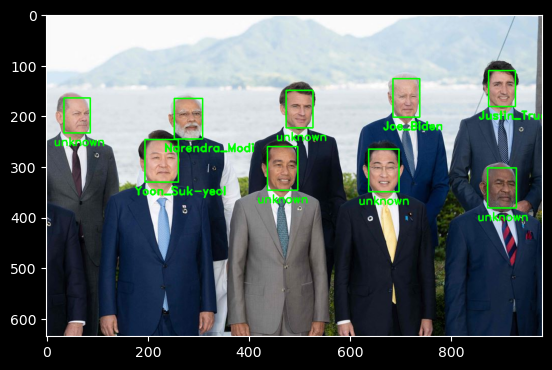

True

In [25]:
# check accuracy find function
clone = test_img.copy()
for embedding in test_embedding:
    starttime = time()

    index, verified = find(embedding["embedding"], X, distance_metric="euclidean_l2")
    box = embedding["facial_area"]
    if verified:
        cv.rectangle(
            clone,
            (box["x"], box["y"]),
            (box["x"] + box["w"], box["y"] + box["h"]),
            (0, 255, 0),
            2,
        )
        cv.putText(
            clone,
            y_unique[y[index]],
            (box["x"] - 20, box["y"] + box["h"] + 25),
            cv.FONT_HERSHEY_DUPLEX,
            0.75,
            (0, 255, 0),
            2,
        )
        print(y_unique[y[index]])
    else:
        cv.rectangle(
            clone,
            (box["x"], box["y"]),
            (box["x"] + box["w"], box["y"] + box["h"]),
            (0, 255, 0),
            2,
        )
        cv.putText(
            clone,
            "unknown",
            (box["x"] - 20, box["y"] + box["h"] + 25),
            cv.FONT_HERSHEY_SIMPLEX,
            0.75,
            (0, 255, 0),
            2,
        )
        print("unknown")

    print("Calculate time: ", time() - starttime)


plt.imshow(clone[:, :, ::-1])
plt.show()
cv.imwrite("result.jpg", clone)

In [101]:
#check accuracy simplefind function
clone = test_img.copy()
for embedding in test_embedding:

    starttime = time()

    index, verified = simplefind(embedding["embedding"], X)
    box = embedding["facial_area"]
    if verified:
        cv.rectangle(
            clone,
            (box["x"], box["y"]),
            (box["x"] + box["w"], box["y"] + box["h"]),
            (0, 255, 0),
            2,
        )
        cv.putText(
            clone,
            y_unique[y[index]],
            (box["x"] - 20, box["y"] + box["h"] + 25),
            cv.FONT_HERSHEY_DUPLEX,
            0.75,
            (0, 255, 0),
            2,
        )
        print(y_unique[y[index]])
    else:
        cv.rectangle(
            clone,
            (box["x"], box["y"]),
            (box["x"] + box["w"], box["y"] + box["h"]),
            (0, 255, 0),
            2,
        )
        cv.putText(
            clone,
            "unknown",
            (box["x"] - 20, box["y"] + box["h"] + 25),
            cv.FONT_HERSHEY_SIMPLEX,
            0.75,
            (0, 255, 0),
            2,
        )
        print("unknown")

    print("Calculate time: ", time() - starttime)


plt.imshow(clone[:, :, ::-1])
plt.show()

NameError: name 'simplefind' is not defined

In [76]:
#speed comparison
model_name = [
    "VGG-Face",
    "Facenet",
    "Facenet512",
    "OpenFace",
    "DeepFace",
    "ArcFace",
]
detector_name = [
    "yunet",
    "yolov8",
    "opencv",
    "ssd",
    "retinaface",
    "fastmtcnn"
]
for name in model_name:
    for detector in detector_name:
        starttime = time()
        verify = DeepFace.verify(
            "test/Hugo_Rafael_Chavez_Frias.jpeg",
            "dataset/Hugo_Chavez/Hugo_Chavez_0006.jpg",
            model_name=name,
            detector_backend=detector,
            distance_metric="euclidean_l2",
        )
        print("Model name: ",name," Detector: ",detector ," Time: ", time() - starttime, verify["verified"])

Model name:  VGG-Face  Detector:  yunet  Time:  0.43727612495422363 True
Model name:  VGG-Face  Detector:  yolov8  Time:  0.44704318046569824 True
Model name:  VGG-Face  Detector:  opencv  Time:  0.5470020771026611 True
Model name:  VGG-Face  Detector:  ssd  Time:  0.530998706817627 True
Model name:  VGG-Face  Detector:  retinaface  Time:  2.9885520935058594 True
Model name:  VGG-Face  Detector:  fastmtcnn  Time:  0.4570026397705078 True
Model name:  Facenet  Detector:  yunet  Time:  0.4096529483795166 True
Model name:  Facenet  Detector:  yolov8  Time:  0.5238373279571533 True
Model name:  Facenet  Detector:  opencv  Time:  0.5145893096923828 True
Model name:  Facenet  Detector:  ssd  Time:  0.5428462028503418 True
Model name:  Facenet  Detector:  retinaface  Time:  2.8585219383239746 False
Model name:  Facenet  Detector:  fastmtcnn  Time:  0.4774954319000244 False
Model name:  Facenet512  Detector:  yunet  Time:  0.40380048751831055 True
Model name:  Facenet512  Detector:  yolov8  Ti

In [26]:
tm.start()
faces = DeepFace.extract_faces(
    test_img, target_size=(160, 160), detector_backend="yolov8", enforce_detection=False
)
tm.stop()
print(f"Time: {tm.getTimeSec()}s")
print(f"FPS: {tm.getFPS()}")
tm.reset()

Time: 0.1170001s
FPS: 8.547001241879281


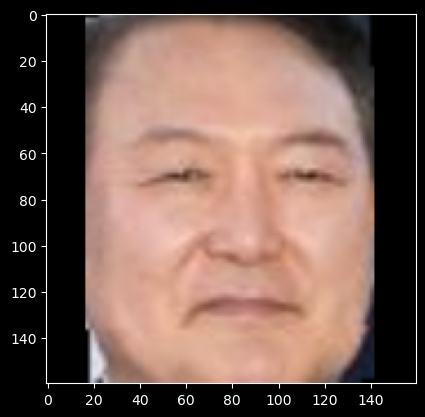

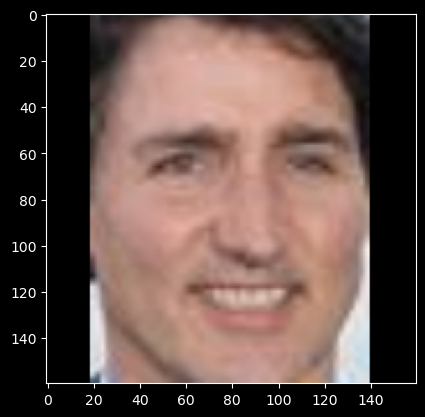

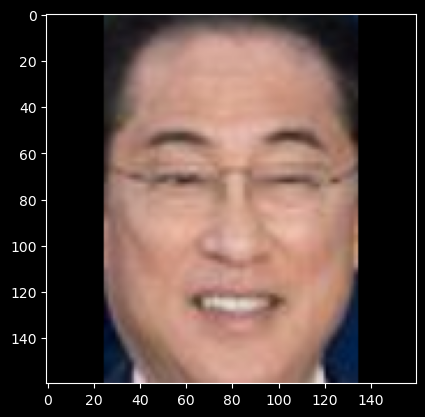

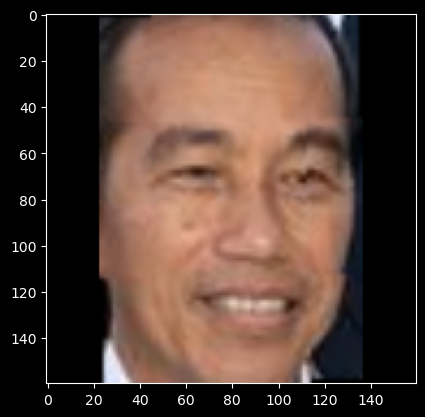

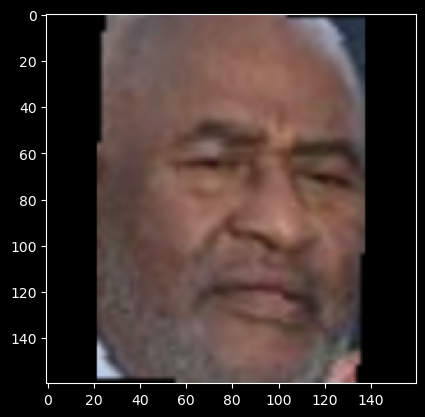

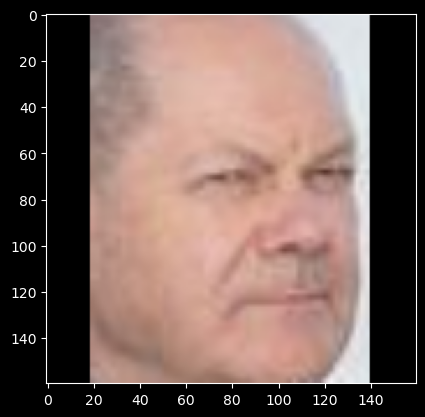

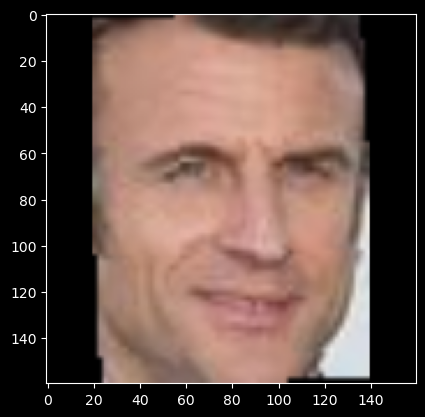

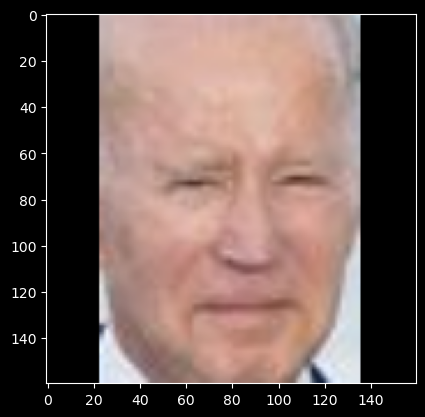

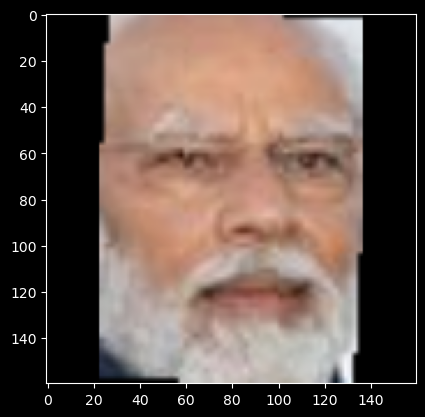

In [74]:
for face in faces:
    plt.imshow(face['face'])
    plt.show()

In [27]:
for face in faces:
    tm.start()
    embedding = DeepFace.represent(
        face["face"],
        model_name="Facenet512",
        detector_backend="skip",
        enforce_detection=False,
        align=True,
    )[0]["embedding"]
    index, verified = find(embedding, X, distance_metric="euclidean_l2")
    tm.stop()
    print(y_unique[y[index]] if verified else "unknown")
    print(f"Time: {tm.getTimeSec()}s")
    tm.reset()

Min distance:  0.7297358555406669
Justin_Trudeau
Time: 0.3270386s
Min distance:  0.8918458890779062
unknown
Time: 0.3658579s
Min distance:  0.5454342765770486
Yoon_Suk-yeol
Time: 0.3587876s
Min distance:  1.090691298677759
unknown
Time: 0.3185236s
Min distance:  0.9922149588647503
unknown
Time: 0.3996257s
Min distance:  0.9471225112080806
unknown
Time: 0.3618028s
Min distance:  0.706071357645363
Joe_Biden
Time: 0.3557666s
Min distance:  0.6827759050220101
Narendra_Modi
Time: 0.3497183s
Min distance:  0.972063491395361
unknown
Time: 0.3491734s


In [28]:
for face in faces:
    tm.start()

    with torch.no_grad():

        embedding = (
            resnet(

                torch.from_numpy(face["face"].copy())
                .cuda()
                .permute(2, 0, 1)
                .unsqueeze(0)
                .float()
            )

        )[0]
    index, verified = find(embedding.cpu().numpy(), X, distance_metric="euclidean_l2")
    print(y_unique[y[index]] if verified else "unknown")
    tm.stop()


    print(f"Time: {tm.getTimeSec()}s")
    tm.reset()

Min distance:  0.7297357320785522
Justin_Trudeau
Time: 1.213782s
Min distance:  0.8918460011482239
unknown
Time: 0.0298002s
Min distance:  0.5454342365264893
Yoon_Suk-yeol
Time: 0.0297444s
Min distance:  1.0906915664672852
unknown
Time: 0.0381777s
Min distance:  0.9922149181365967
unknown
Time: 0.0328052s
Min distance:  0.94712233543396
unknown
Time: 0.0287518s
Min distance:  0.7060713171958923
Joe_Biden
Time: 0.0293418s
Min distance:  0.6827759146690369
Narendra_Modi
Time: 0.0337081s
Min distance:  0.9720634818077087
unknown
Time: 0.0400859s


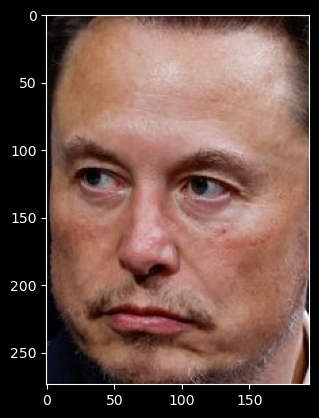

In [81]:
img = cv.imread("test/elon.jpg")
result = yolo(img, mode="predict", conf=0.6, imgsz=320, scale=0.4, verbose=False)

boxes = result[0].boxes
if len(boxes) > 0:
    for box in boxes:
        top_left_x = int(box.xyxy.tolist()[0][0])
        top_left_y = int(box.xyxy.tolist()[0][1])
        bottom_right_x = int(box.xyxy.tolist()[0][2])
        bottom_right_y = int(box.xyxy.tolist()[0][3])

        img_face = img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

plt.imshow(img_face[:, :, ::-1])

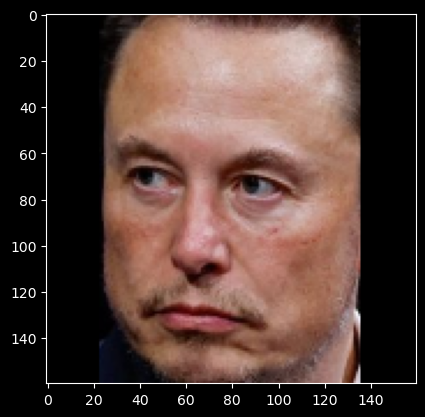

In [82]:
aligned = DeepFace.extract_faces(
    img_face, target_size=(160, 160), detector_backend="skip", align=True
)[0]["face"]
plt.imshow(aligned)

In [83]:
with torch.no_grad():
    img_embedding = (
        resnet(
            torch.from_numpy(aligned.copy())
            .cuda()
            .permute(2, 0, 1)
            .unsqueeze(0)
            .float()
        )
    )[0]
img_embedding = img_embedding.cpu().numpy()
index, verified = find(img_embedding, X, distance_metric="euclidean_l2")
print(y_unique[y[index]] if verified else "unknown")

Min distance:  0.584982693195343
Elon_Musk


In [85]:
tm.start()
dis, idx = face_embeddings.search(img_embedding.reshape(1,512) , 1)
tm.stop()
print(f"Time: {tm.getTimeSec()}s")
tm.reset()
print(y_unique[y[idx[0][0]]] if dis[0][0] <= 0.5 else "unknown", dis[0][0], sep=" ")

Time: 0.0014101s
Elon_Musk 0.34220475


## Batch Processing

In [75]:
test_img = cv.imread("test/images.jpg")
tm = cv.TickMeter()

In [77]:
result = yolo(test_img, mode="predict", conf=0.45, imgsz=32 * 12, scale=0.6)
boxes = result[0].boxes

In [78]:
bounding_boxes = []
faces = []
for box in boxes:
    top_left_x = int(box.xyxy.tolist()[0][0])
    top_left_y = int(box.xyxy.tolist()[0][1])
    bottom_right_x = int(box.xyxy.tolist()[0][2])
    bottom_right_y = int(box.xyxy.tolist()[0][3])

    bounding_boxes.append([top_left_x, top_left_y, bottom_right_x, bottom_right_y])
    face = test_img[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
    faces.append(face)

In [79]:
# preprocessing face
aligned = []
for face in faces:
    aligned.append(
        DeepFace.extract_faces(
            face, target_size=(160, 160), detector_backend="skip", align=True
        )[0]["face"]
    )

In [80]:
processed = torch.from_numpy(np.array(aligned)).permute(0, 3, 1, 2).float().cuda()

In [81]:
tm.start()
with torch.no_grad():
    embeddings = resnet(processed)
tm.stop()
print(f"Time: {tm.getTimeSec()}s")
tm.reset()

Time: 0.0958344s


In [85]:
clone = test_img.copy()
for i in range(len(boxes)):
    dis, idx = face_embeddings.search(embeddings[i].cpu().numpy().reshape(1, 512), 1)
    # draw bounding box
    cv.rectangle(
        clone,
        (bounding_boxes[i][0], bounding_boxes[i][1]),
        (bounding_boxes[i][2], bounding_boxes[i][3]),
        (0, 255, 0),
        2,
    )
    # draw label
    cv.putText(
        clone,
        y_unique[y[idx[0][0]]] if dis[0][0] <= 0.61 else "unknown",
        (bounding_boxes[i][0], bounding_boxes[i][1] - 10),
        cv.FONT_HERSHEY_SIMPLEX,
        0.75,
        (0, 255, 0),
        2,
    )

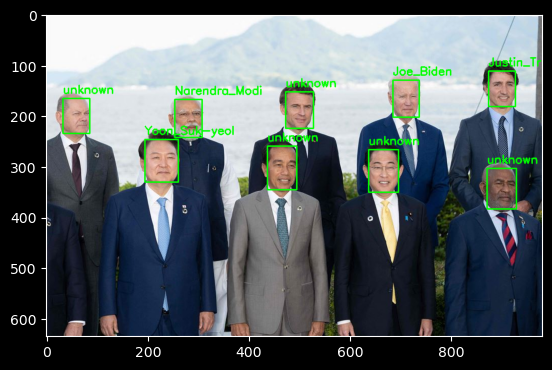

In [86]:
plt.imshow(clone[:, :, ::-1])
plt.show()